## Elastic Full Procrustes Means for Sparse and Irregular Planar Curves

In [16]:
library(elasdics)

Load some datasets with random rotation and scaling.

In [17]:
source("/home/mnl/Statistik/masterthesis/code/datasets.R")
set.seed(18)

data_curves <- curves.spiral(n_curves=4, rotate=TRUE, scale=TRUE, center=TRUE)
data_curves2 <- curves.digit3(rotate=TRUE, scale=TRUE, center=TRUE)

Take a look at the data curves.

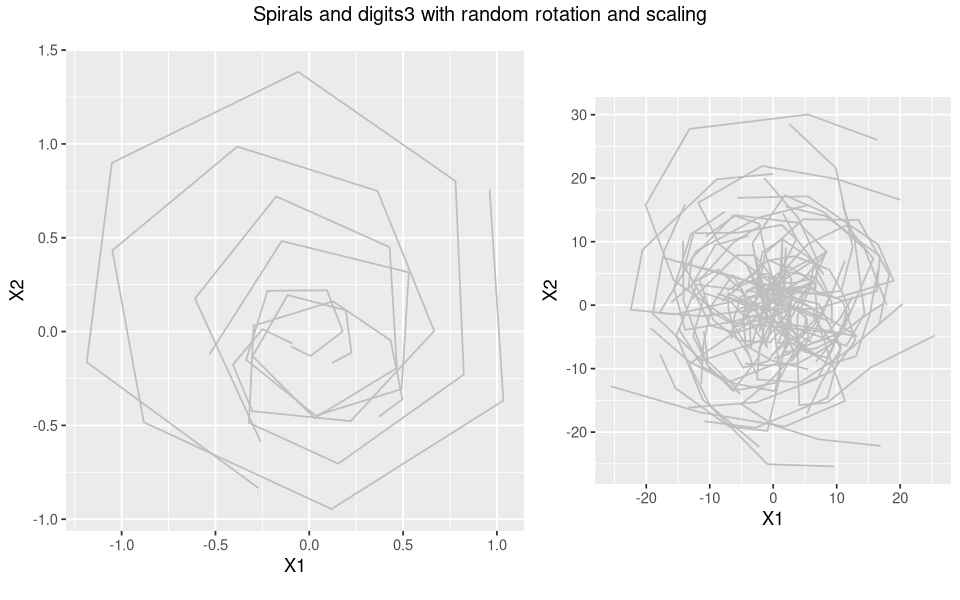

In [18]:
library(ggplot2)
library(gridExtra)
library(dplyr)

p1 <- ggplot(bind_rows(data_curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed()

p2 <- ggplot(bind_rows(data_curves2, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed()

# Display plots in smaller size
options(repr.plot.width=8, repr.plot.height=5)

grid.arrange(p1, p2, nrow=1, widths=5:4, top="Spirals and digits3 with random rotation and scaling")

#### Calculate Smooth Elastic Mean
-> switch out ```compute_elastic_mean``` function in package namespace (now with additional ```proc2d``` parameter).

-> define ```fit_mean_proc2d``` function and assign to package namespace.

In [50]:
source("/home/mnl/Statistik/masterthesis/code/modify_compute_elastic_mean.R")  # Switcheroo

# Turn of warnings
defaultW <- getOption("warn")
options(warn = -1)

# Compute Means
knots <- seq(0,1, length = 31)
smooth_elastic_mean <- compute_elastic_mean(data_curves, knots = knots, proc2d = TRUE)
knots2 <- seq(0,1, length = 31)
smooth_elastic_mean2 <- compute_elastic_mean(data_curves2, knots = knots2, proc2d = TRUE)

# Turn on warnings
options(warn = defaultW)

#### Plot results.
-> Mean looks ok. Problem are the procrustes fits.

Procrustes fit of curve $f(t)$ calculated as $f_p(t) = \text{b} \cdot e^{i\text{G}} f(t)$. Get mean using ```get_evals()```.

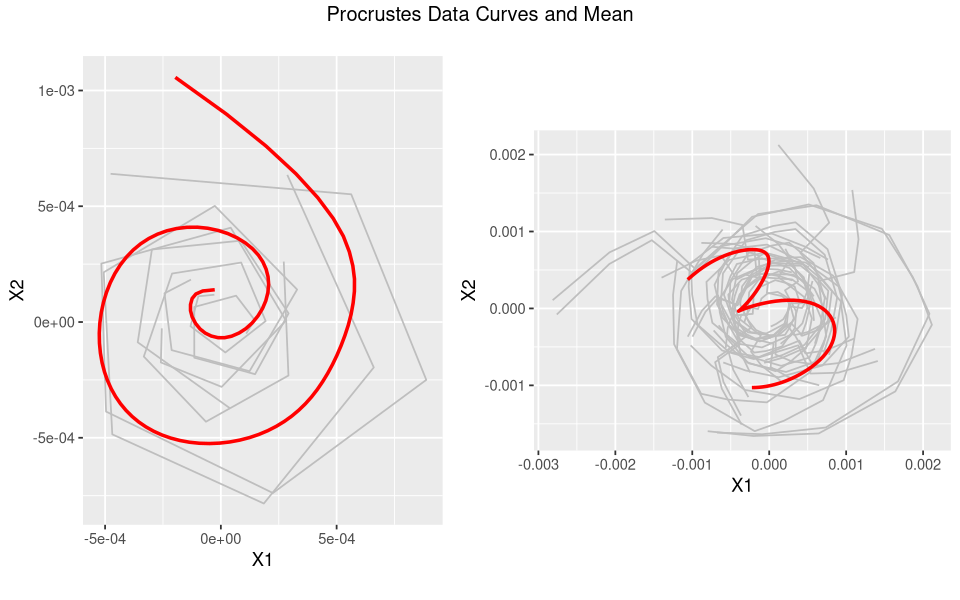

In [51]:
p1 <- ggplot(bind_rows(smooth_elastic_mean$procrustes_fits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

p2 <- ggplot(bind_rows(smooth_elastic_mean2$procrustes_fits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean2), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

grid.arrange(p1, p2, nrow=1, widths=8:9, top="Procrustes Data Curves and Mean")

Plot Results. With Procrustes fit calculated on SRV curve $q_p(t) = \sqrt{\text{b}} \cdot e^{i\text{G}} q(t)$.

$f_p(t)$ and the mean are transformed to data_curve space via ```get_points_from_srv()```. 

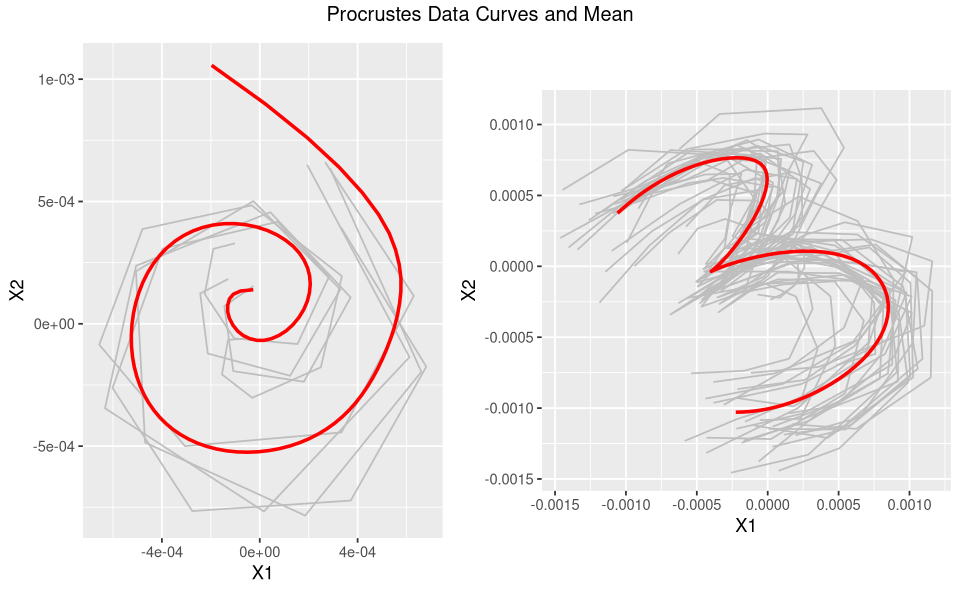

In [52]:
p1 <- ggplot(bind_rows(smooth_elastic_mean$procrustes_fits_on_srv_basis, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

p2 <- ggplot(bind_rows(smooth_elastic_mean2$procrustes_fits_on_srv_basis, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean2), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

grid.arrange(p1, p2, nrow=1, widths=8:9, top="Procrustes Data Curves and Mean")

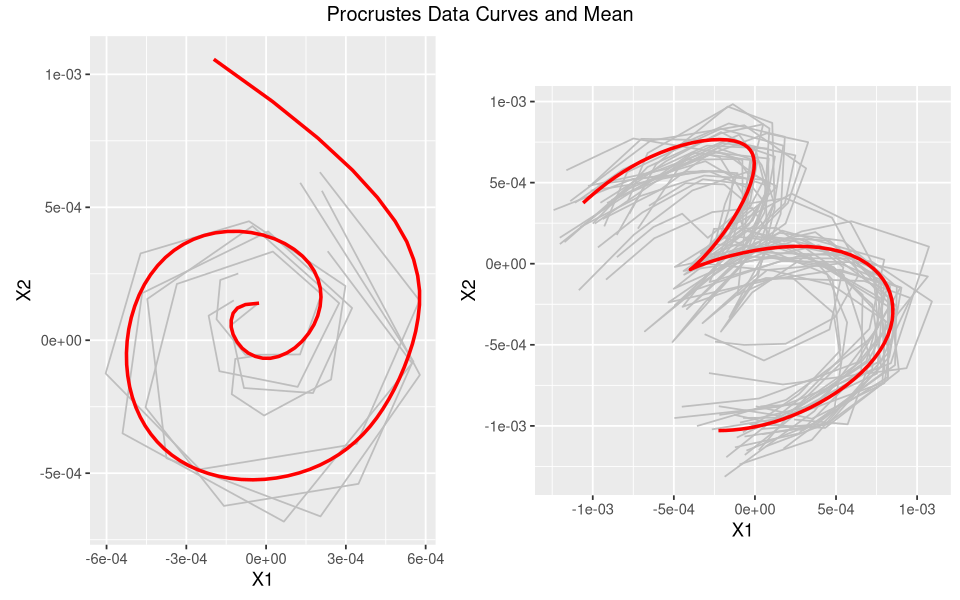

In [53]:
type="smooth"
align_curve_proc2d <- function(data_curve, mean, grid.len = 101){
    arg.grid = seq(0,1,len = grid.len)
    mean_eval = get_evals(mean, t=arg.grid)
    mean_eval = complex(real = mean_eval[,1], imaginary = mean_eval[,2])
    # Eval curve on arg.grid
    b_coefs <- as.matrix(data_curve[,c(-1,-2)])
    b_eval <- elasdics:::make_design(arg.grid, knots = data_curve$t_optim, closed = FALSE, type = type) %*% b_coefs
    b_eval <- complex(real = b_eval[,1], imaginary = b_eval[,2])
    # Calc proc2d fit
    bm <- Conj(b_eval) %*% mean_eval
    bb <- Conj(b_eval) %*% b_eval
    b_compl <- complex(real = b_coefs[,1], imaginary = b_coefs[,2])
    pfit <- as.vector(bm) * b_compl / as.vector(bb)
    data.frame(t = data_curve$t, t_optims = data_curve$t, X1 = Re(pfit), X2 = Im(pfit))
}

pfits <- lapply(smooth_elastic_mean$data_curves, function(x) {
        align_curve_proc2d(x, smooth_elastic_mean)
})
pfits2 <- lapply(smooth_elastic_mean2$data_curves2, function(x) {
    align_curve_proc2d(x, smooth_elastic_mean2)
})
p1 <- ggplot(bind_rows(pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

p2 <- ggplot(bind_rows(pfits2, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean2), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

grid.arrange(p1, p2, nrow=1, widths=8:9, top="Procrustes Data Curves and Mean")

#### Output
Note: ```$coefs_smooth``` is the leading eigenvalue of the cov surface (on grid ```$knots_smooth```)

In [54]:
print(smooth_elastic_mean)

$type
[1] "smooth"

$coefs
                X1           X2
 [1,] -0.081219567  0.000000000
 [2,] -0.015597032 -0.051224124
 [3,]  0.028888875 -0.050859169
 [4,]  0.052227183 -0.018811855
 [5,]  0.055241515  0.022018875
 [6,]  0.039371211  0.050183812
 [7,]  0.010461933  0.059767225
 [8,] -0.022606598  0.054772130
 [9,] -0.050975445  0.039383791
[10,] -0.066231185  0.017667772
[11,] -0.067277894 -0.006679612
[12,] -0.058117282 -0.030349505
[13,] -0.042842524 -0.049993339
[14,] -0.025503727 -0.062480202
[15,] -0.008136849 -0.067071258
[16,]  0.008813715 -0.065039971
[17,]  0.024961288 -0.057765936
[18,]  0.039886046 -0.046566236
[19,]  0.052692034 -0.032664326
[20,]  0.062047353 -0.017149619
[21,]  0.066552657 -0.001099695
[22,]  0.064953325  0.014411913
[23,]  0.057828762  0.028646350
[24,]  0.047748031  0.041199738
[25,]  0.037409739  0.051707667
[26,]  0.029343471  0.059812265
[27,]  0.021297706  0.065992230
[28,]  0.005276050  0.071732571
[29,] -0.027189767  0.078581060
[30,] -0.0821